# Implementing uncertainty associated with f-factor estimations to summarize data using the Kent distribution

## Import scientific Python packages

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import mode
import pandas as pd

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib

import cartopy.crs as ccrs
#import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D

%config InlineBackend.figure_format = 'retina'

## functions for plotting spherical direction distributions and contours

In [2]:
def bin_trace(lon_samples, lat_samples, resolution):
    """
    Given a trace of samples in longitude and latitude, bin them
    in latitude and longitude, and normalize the bins so that
    the integral of probability density over the sphere is one.

    The resolution keyword gives the number of divisions in latitude.
    The divisions in longitude is twice that.
    """
    lats = np.linspace(-90., 90., resolution, endpoint=True)
    lons = np.linspace(-180., 180., 2 * resolution, endpoint=True)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    hist = np.zeros_like(lon_grid)

    dlon = 360. / (2. * resolution)
    dlat = 180. / resolution

    for lon, lat in zip(lon_samples, lat_samples):

        lon = np.mod(lon, 360.)
        if lon > 180.:
            lon = lon - 360.
        if lat < -90. or lat > 90.:
            # Just skip invalid latitudes if they happen to arise
            continue

        lon_index = int(np.floor((lon + 180.) / dlon))
        lat_index = int(np.floor((lat + 90.) / dlat))
        hist[lat_index, lon_index] += 1

    lat_grid += dlat / 2.
    lon_grid += dlon / 2.
    return lon_grid, lat_grid, hist


def density_distribution(lon_samples, lat_samples, resolution=30):
    count = len(lon_samples)
    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)
    return lon_grid, lat_grid, hist / count


def cumulative_density_distribution(lon_samples, lat_samples, resolution=30):

    lon_grid, lat_grid, hist = bin_trace(lon_samples, lat_samples, resolution)

    # Compute the cumulative density
    hist = hist.ravel()
    i_sort = np.argsort(hist)[::-1]
    i_unsort = np.argsort(i_sort)
    hist_cumsum = hist[i_sort].cumsum()
    hist_cumsum /= hist_cumsum[-1]

    return lon_grid, lat_grid, hist_cumsum[i_unsort].reshape(lat_grid.shape)


def plot_distributions(ax, lon_samples, lat_samples, to_plot='d', resolution=100, **kwargs):

    cmap=kwargs.get('cmap', 'viridis')

    artists = []

    if 'd' in to_plot:
        lon_grid, lat_grid, density = density_distribution(
            lon_samples, lat_samples, resolution)
        density = ma.masked_where(density <= 0.05*density.max(), density)
        a = ax.pcolormesh(lon_grid, lat_grid, density, cmap=cmap,
                          transform=ccrs.PlateCarree())
        artists.append(a)

    if 'e' in to_plot:
        lon_grid, lat_grid, cumulative_density = cumulative_density_distribution(
            lon_samples, lat_samples, resolution)
        a = ax.contour(lon_grid, lat_grid, cumulative_density, levels=[
                       0.95], colors=kwargs.get('colors', 'k'), transform=ccrs.PlateCarree(), 
                       linewidths=kwargs.get('lw', 1), zorder = kwargs.get('zorder', 100))
        artists.append(a)

    if 's' in to_plot:
        a = ax.scatter(lon_samples, lat_samples, color=kwargs.get('color', 'C0'), alpha=0.1, transform=ccrs.PlateCarree(), edgecolors=None, **kwargs)
        artists.append(a)

    return artists

## Import data and filter to the `ht` (DRM) component

In [3]:
Cutface_specimens = pd.read_csv('../data/Pmag/cutface/specimens_w_strat_gs.txt', sep='\t', header=1)

Cutface_lat = 47.73055
Cutface_lon = -90.44128

Cutface_specimens['slat'] = Cutface_lat
Cutface_specimens['slon'] = Cutface_lon

specimens_ht_tc = Cutface_specimens[(Cutface_specimens['dir_comp']=='ht') & (Cutface_specimens['dir_tilt_correction']==100)]
mean_ht = ipmag.fisher_mean(specimens_ht_tc['dir_dec'].tolist(),specimens_ht_tc['dir_inc'].tolist())

specimens_ht_tc['plon'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[0]
specimens_ht_tc['plat'] = pmag.dia_vgp(specimens_ht_tc[['dir_dec', 'dir_inc', 'dir_alpha95', 'slat', 'slon']].to_numpy())[1]

uncorrected_mean_pole = ipmag.fisher_mean(dec=specimens_ht_tc['plon'].tolist(), inc=specimens_ht_tc['plat'].tolist())
ipmag.print_pole_mean(uncorrected_mean_pole)

Plon: 178.5  Plat: 23.0
Number of directions in mean (n): 157
Angular radius of 95% confidence (A_95): 1.7
Precision parameter (k) estimate: 44.0


In [4]:
uncorrected_plon, uncorrected_plat, A95 = np.round([uncorrected_mean_pole['dec'], uncorrected_mean_pole['inc'], uncorrected_mean_pole['alpha95']],1)
uncorrected_plon, uncorrected_plat, A95

(178.5, 23.0, 1.7)

Bootstrapping.... be patient

The original inclination was: 29.43

The corrected inclination is: 40.74
with bootstrapped confidence bounds of: 33.49 to 47.97
and elongation parameter of: 1.93
The flattening factor is: 0.64
with bootstrapped confidence bounds of: 0.85 to 0.51


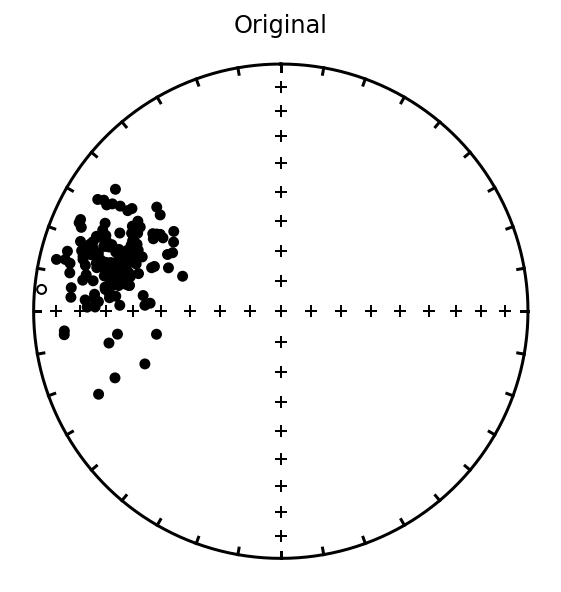

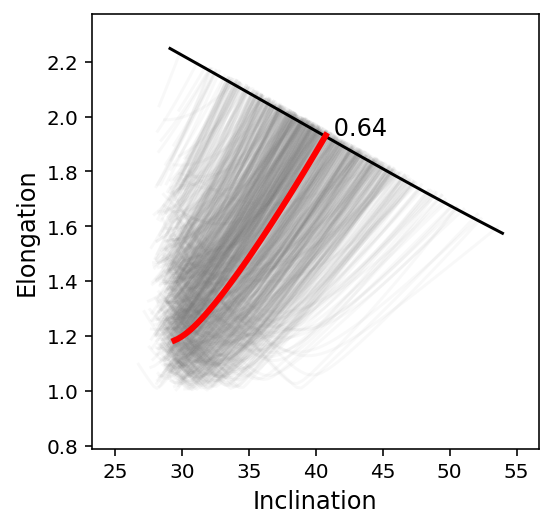

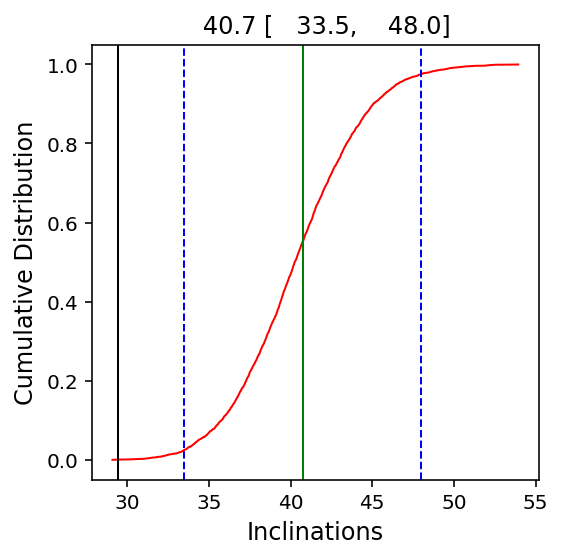

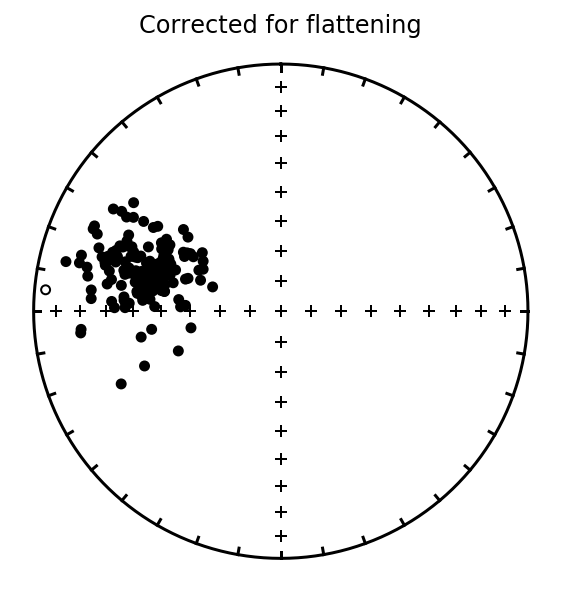

In [5]:
EI_incs, EI_elongs, EI_fs = ipmag.find_ei(specimens_ht_tc[['dir_dec', 'dir_inc']].to_numpy(), nb=5000, 
                                    return_values = 1, save=0, save_folder='../code_output', fmt='png', tight_axes=1)

### show all unsquished directions according to E/I bootstrap results

note - make sure to reduce the amount of f used in the equal area plot, otherwise the cell will hang due to too many directions to plot

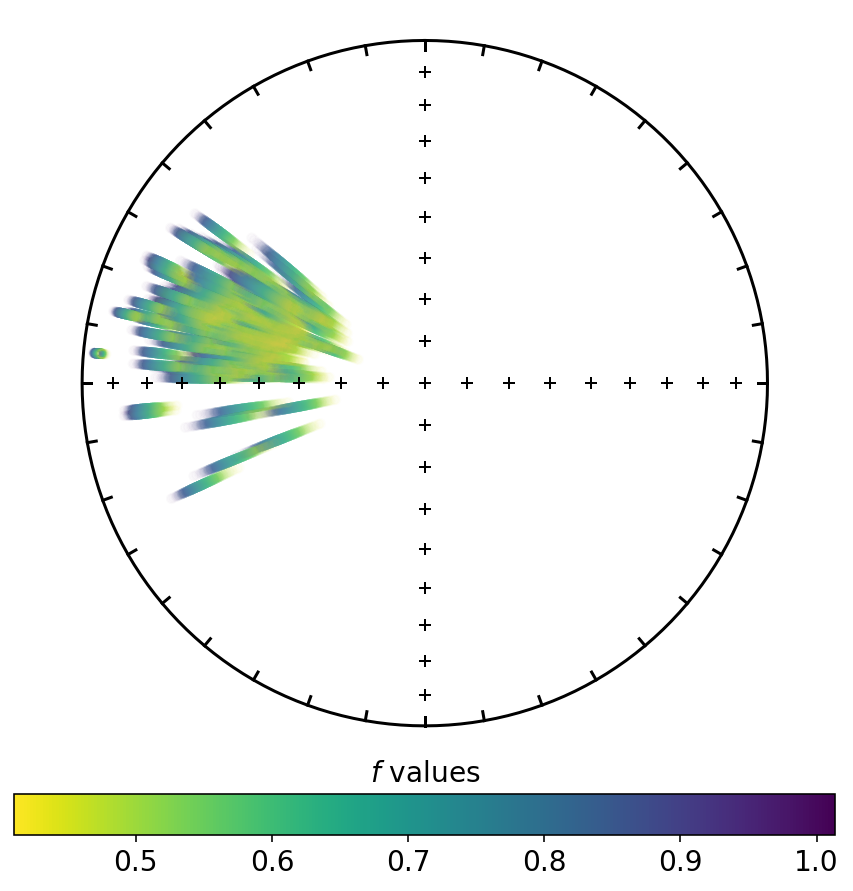

In [6]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()

plt.figure(figsize=(6,6))
ipmag.plot_net()
cNorm  = matplotlib.colors.Normalize(vmin=min(EI_fs), vmax=max(EI_fs))
f_scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

for f in EI_fs[::5]:
    rgba = f_scalarMap.to_rgba(f)
    hex_color = colors.rgb2hex(rgba)
    
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    ipmag.plot_di(specimens_ht_tc_decs, unsquish_incs, color = hex_color, alpha=0.02)
cb = plt.colorbar(f_scalarMap,orientation='horizontal',fraction=0.05, pad=0.05)
cb.ax.tick_params(labelsize=14)
cb.ax.set_title(label='$f$ values', fontsize=14);
# plt.savefig('../code_output/bootstrap_directions.png', dpi=300, bbox_inches='tight')

<Figure size 576x576 with 0 Axes>

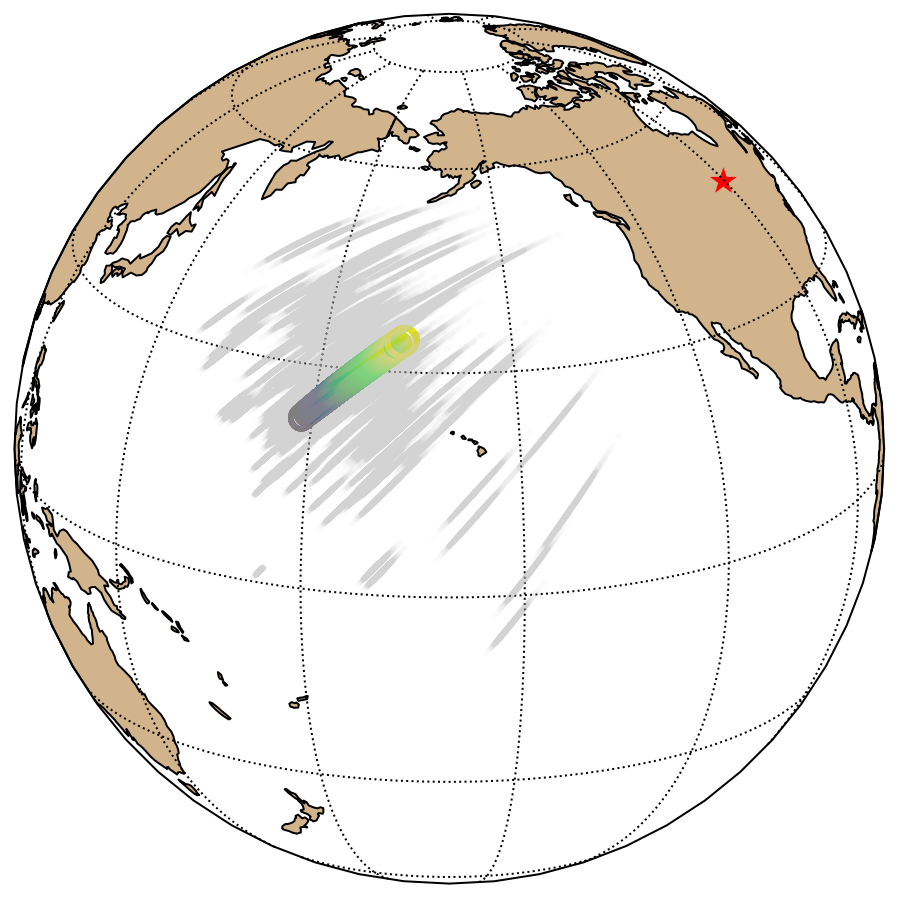

In [7]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)

ipmag.plot_pole(m, Cutface_lon, Cutface_lat, 0, label='Cut Face Creek site location', color='r', edgecolor='none', marker = '*', markersize=200)

for f in EI_fs[::5]:
    rgba = f_scalarMap.to_rgba(f)
    hex_color = colors.rgb2hex(rgba)
    
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    ipmag.plot_vgp(m, unsquish_lons, unsquish_lats, color = 'lightgray', edge=None, markersize=5, alpha=0.01)

    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    ipmag.plot_pole(m, unsquish_VGPs_mean['dec'], unsquish_VGPs_mean['inc'], unsquish_VGPs_mean['alpha95'], 
                    color=hex_color, edgecolor='none', markersize=5, mean_alpha=1, A95_alpha=1)
# plt.savefig('../code_output/bootstrap_poles.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 576x576 with 0 Axes>

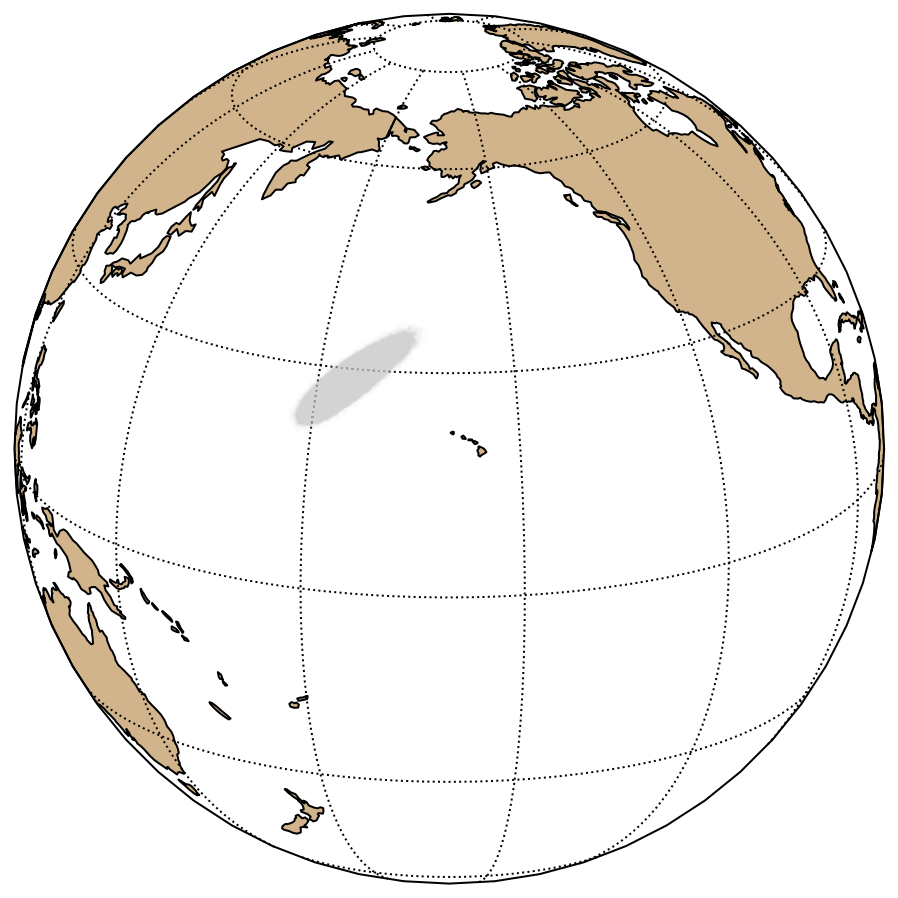

In [8]:
specimens_ht_tc_decs = specimens_ht_tc['dir_dec'].tolist()
specimens_ht_tc_alpha95s = specimens_ht_tc['dir_alpha95'].tolist()
slons = specimens_ht_tc['slon'].tolist()
slats = specimens_ht_tc['slat'].tolist()

mean_lons = []
mean_lats = []

for f in EI_fs:
    unsquish_incs = ipmag.unsquish(specimens_ht_tc['dir_inc'].tolist(), f)
    unsquish_VGPs = pmag.dia_vgp(np.array([specimens_ht_tc_decs, unsquish_incs, specimens_ht_tc_alpha95s, slats, slons]).T)
    unsquish_lons, unsquish_lats = unsquish_VGPs[0], unsquish_VGPs[1]
    unsquish_VGPs_mean = ipmag.fisher_mean(unsquish_lons, unsquish_lats)
    resampled_lons, resampled_lats = ipmag.fisher_mean_resample(alpha95=unsquish_VGPs_mean['alpha95'], n=100, 
                                                   dec=unsquish_VGPs_mean['dec'], inc=unsquish_VGPs_mean['inc'], di_block=0)
    mean_lons.extend(resampled_lons)
    mean_lats.extend(resampled_lats)

plt.figure(figsize=(8,8))
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_vgp(m, mean_lons, mean_lats, color='lightgrey', edge='none', markersize=5, alpha=0.02)

# plt.savefig('../code_output/bootstrap_pole_resample.png', dpi=300, bbox_inches='tight')

In [9]:
kent_distribution_95 = ipmag.kent_distribution_95(dec=mean_lons,inc=mean_lats) 
kent_distribution_95

{'dec': 184.2882218091266,
 'inc': 28.05521446051757,
 'n': 500000,
 'Zdec': 297.7976399396668,
 'Zinc': 36.8141366514713,
 'Edec': 67.33472842888608,
 'Einc': 40.380939195392926,
 'Zeta': 6.712790644932443,
 'Eta': 1.8318523136504885,
 'R1': 0.9987752128466719,
 'R2': 0.0021048350797403673}

In [10]:
ipmag.print_kent_mean(kent_distribution_95)

Plon: 184.3  Plat: 28.1
Major axis lon: 297.8  Major axis lat: 36.8
Minor axis lon: 67.3  Minor axis lat: 40.4
Major axis angle of 95% ellipse (Zeta): 6.7
Minor axis angle of 95% ellipse (Eta): 1.8
Number of directions in mean (n): 500000


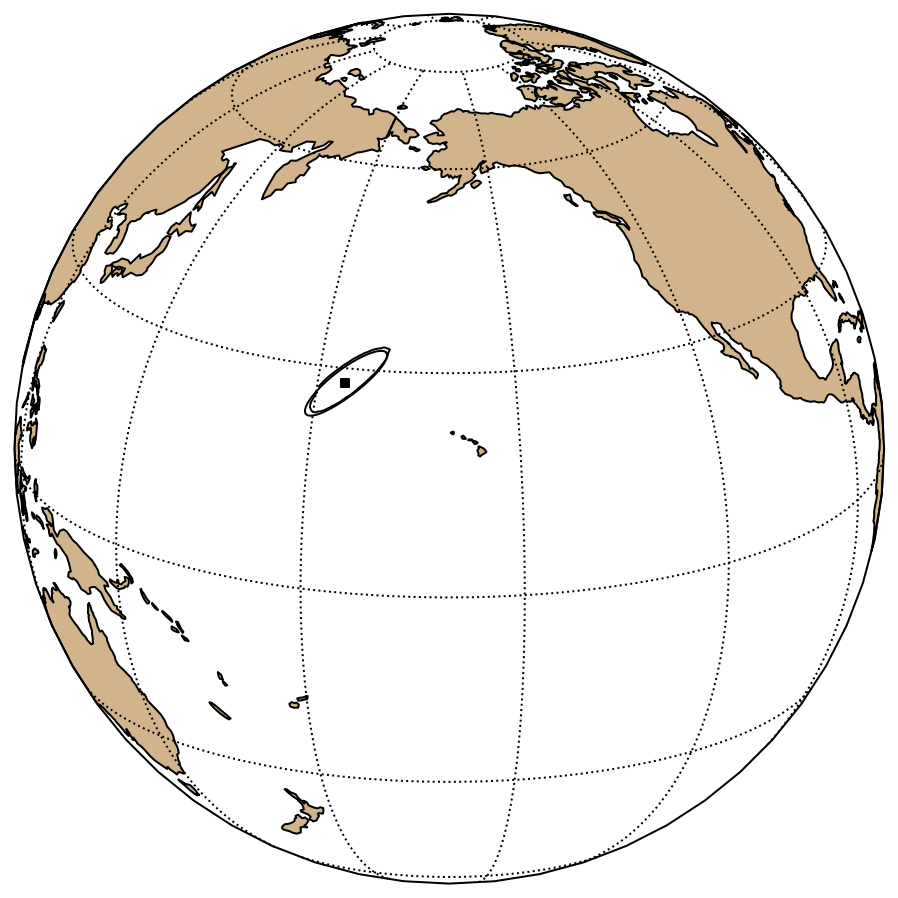

In [11]:
m = ipmag.make_orthographic_map(200, 20)
plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 400, cmap='viridis')
ipmag.plot_pole_ellipse(m,kent_distribution_95)
plt.show()

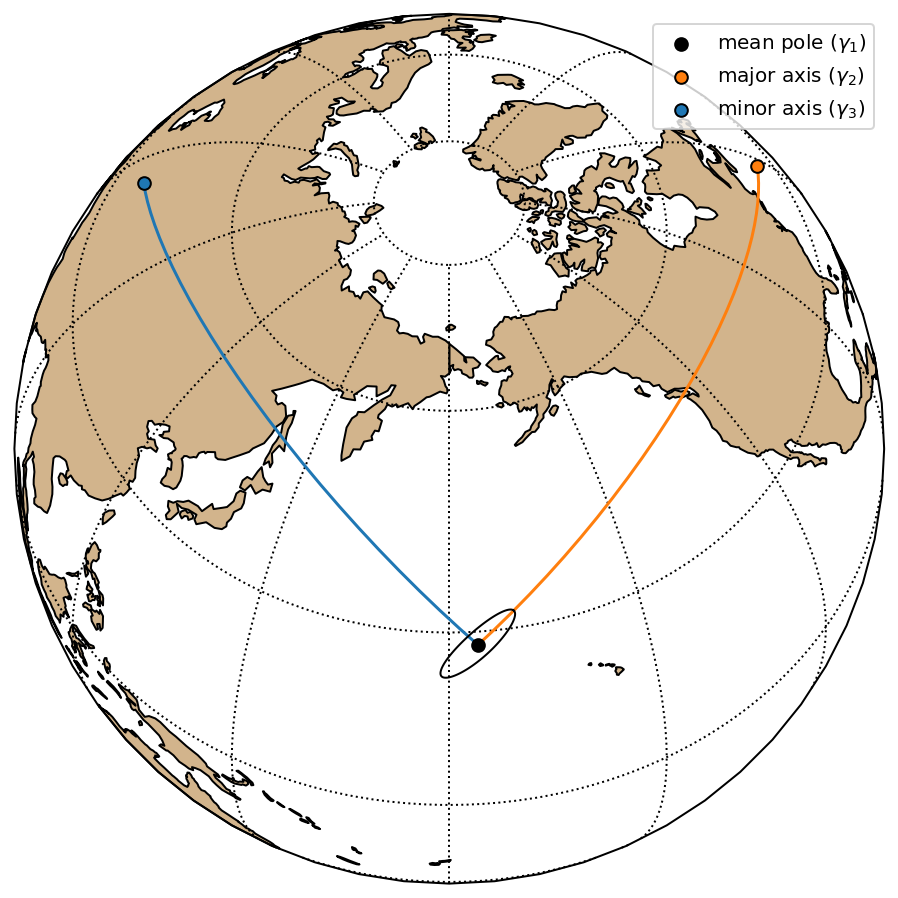

In [12]:
map_axis = ipmag.make_orthographic_map(central_longitude=180,central_latitude=55,figsize=(10, 8))
ipmag.plot_vgp(map_axis,vgp_lon=kent_distribution_95['dec'],vgp_lat=kent_distribution_95['inc'],
               color='black',markersize=40,label='mean pole ($\gamma_1$)')
ipmag.plot_vgp(map_axis,vgp_lon=kent_distribution_95['Zdec'],vgp_lat=kent_distribution_95['Zinc'],
               color='C1',markersize=40,label='major axis ($\gamma_2$)')
ipmag.plot_vgp(map_axis,vgp_lon=kent_distribution_95['Edec'],vgp_lat=kent_distribution_95['Einc'],
               color='C0',markersize=40,label='minor axis ($\gamma_3$)')
map_axis.plot([kent_distribution_95['Edec'],kent_distribution_95['dec']],
              [kent_distribution_95['Einc'],kent_distribution_95['inc']],transform=ccrs.Geodetic())
map_axis.plot([kent_distribution_95['Zdec'],kent_distribution_95['dec']],
              [kent_distribution_95['Zinc'],kent_distribution_95['inc']],transform=ccrs.Geodetic())
ipmag.plot_pole_ellipse(map_axis,kent_distribution_95)
plt.legend()
plt.show()

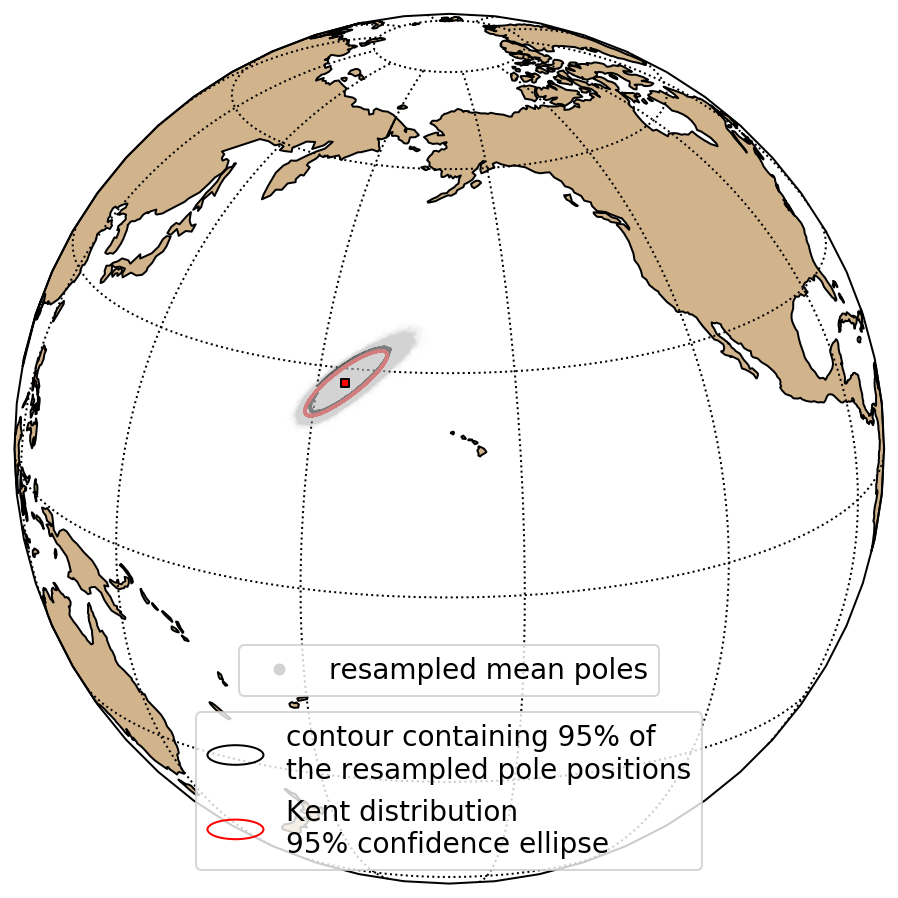

In [13]:
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_vgp(m, mean_lons, mean_lats, color='lightgray', edge='none', markersize=5, alpha=0.01)

plot_distributions(m, mean_lons, mean_lats, to_plot='e', resolution = 400, colors='k', lw=2, zorder = 2)
ipmag.plot_pole_ellipse(m,kent_distribution_95, color='red', lw=2)
# ipmag.plot_pole(m,uncorrected_plon, uncorrected_plat, 1.8, color='orange', label='uncorrected ')

# m.legend()
ellipse_colors = ["k","r"]
texts = ["contour containing 95% of\nthe resampled pole positions", "Kent distribution\n95% confidence ellipse"]
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


c = [mpatches.Circle((0.5, 0.5), 1, edgecolor=ellipse_colors[i], facecolor='none',linewidth=1) for i in range(len(texts))]
legend_1 = plt.legend(handles=[Line2D([], [], color='lightgray', marker='o', markersize=5, lw=0,
                         label='resampled mean poles')], bbox_to_anchor=[0.5, 0.2], loc=8, fontsize=14)
plt.gca().add_artist(legend_1)
plt.legend(c,texts, loc='lower center', ncol=1, handler_map={mpatches.Circle: HandlerEllipse()}, fontsize=14)
# print(c)
# plt.savefig('../code_output/Kent_ellipse.png', bbox_inches='tight', dpi=300)
plt.show()

## make find_compilation_kent function that allows compilation-based correction of legacy poles

>let's assume we only have site lat, pole lat, pole lon, pole A95 stats for a legacy sedimentary pole and we try to generate a Kent distribution representing the uncertainty in plat of the pole using our compilation results

### import the compilation file

In [14]:
def find_compilation_kent(plon, plat, A95, slon, slat, f_from_compilation=None, n=1000, n_fish=100, return_poles=True, return_kent_stats=True):
    '''
    Applies a series of assumed flattening factors given a normal distribution of f factors to a legacy 
    sedimentary paleomagnetic pole where only pole longitude, pole latitude, A95, site longitude, site latitude,
    are available. 
    First calculate the paleomagnetic direction at the site of the mean pole using plon, plat using pmag.vgp_di 
    Draw n resamples from a normal distribution for f with prescribed mu and std
    Unsquish the directions with the resampled f factors, then convert the mean directions back to pole space
    Assume the pole is well-grouped and the A95 does not change much if the original site-level data were available
    Resample n_fish mean poles from the fisher distribution given the unsquished plon, plat, and A95
    This will result in a total of n*n_fish number of resampled mean poles
    Summarize the distribution of the mean poles using a Kent distribution 
    
    Required Parameters
    -----------
    plon: legacy mean pole longitude
    plat: legacy mean pole latitude
    A95: legacy mean pole A95 
    slon: site longitude
    slat: site latitude
    mu: mean of the normal distribution, 
        for rocks with hematite carrying the DRM, the recommended value is 0.57
        for rocks with magnetite carrying the DRM the recommended value is 0.67
        for rocks with both hematite and magnetite carrying the DRM, the recommended value is 0.67
        if you would like to use all data compiled for the three categories above, use 0.62
    std: one standard deviation of the normal disttribution 
        for rocks with hematite carrying the DRM, the recommended value is 0.13
        for rocks with magnetite carrying the DRM the recommended value is 0.14
        for rocks with both hematite and magnetite carrying the DRM, the recommended value is 0.11
        if you would like to use all data compiled for the three categories above, use 0.14
    these values are based on the compilation of Pierce et al., 2022 Table S1. 

    Optional Parameters:
    -----------
    n: number of resample from the normal distribution
    n_fish: number of resample from each Fisher mean pole position
    return_poles: whether or not to return the resampled mean pole positions, default is True
    return_kent_stats: whether or not to return the calculate kent disttribution statistics of the resampled mean poles
        default is True

    '''

    # get the uncorrected dec and inc from a given paleomagnetic pole
    original_dec, original_inc = pmag.vgp_di(plat, plon, slat, slon)
    # compilation f value list
#     f_from_compilation = pd.Series([0.49, 0.77, 0.63, 0.59, 0.57, 0.4, 0.63, 0.66, 0.63, 0.49, 0.49, 0.58, 0.54, 0.73, 0.97, 
#                           0.59, 0.84, 0.9, 0.78, 0.83, 0.58, 0.94, 0.78, 0.9, 0.68, 0.48, 0.67, 0.66, 0.7, 0.43, 
#                           0.45, 0.58, 0.58, 0.53, 0.42, 0.51, 0.61, 0.52, 0.62, 0.73, 0.66, 0.55, 0.47, 0.77, 
#                           0.62, 0.54, 0.46, 0.56, 0.64, 0.47, 0.48, 0.44, 0.52, 0.65, 0.81, 0.64, 0.71, 
#                           0.79, 0.65, 0.56, 0.69, 0.43, 0.7, 0.67, 0.65, 0.49, 0.54, 0.64, 0.83, 0.68])
    f_resample=f_from_compilation.sample(n=n, replace=1).tolist()
    
    plt.figure(figsize=(6,6))
    plt.hist(f_resample, alpha=0.6, density=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('resample of compilation f factors', fontsize=16)
    plt.ylabel('density', fontsize=16)
    
    #calculate corrected inclinations
    compilation_incs = [pmag.unsquish(original_inc, f) for f in f_resample]
    # calculate corrected paleolatitudes
    compilation_paleolats = np.degrees(np.arctan(np.tan(np.radians(compilation_incs))/2))
    
    plt.figure(figsize=(6,6))
    plt.hist(compilation_paleolats, alpha=0.6, density=1)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('compilation paleolatitudes ($^\circ$)', fontsize=16)
    plt.ylabel('density', fontsize=16)
    
    compilation_mean_lons = []
    compilation_mean_lats = []

    for i in range(len(f_from_compilation)):
        unsquish_plon, unsquish_plats,_,_ = pmag.dia_vgp(original_dec, compilation_incs[i], A95, slat, slon)
        resampled_lons, resampled_lats = ipmag.fisher_mean_resample(alpha95=A95, n=n_fish, 
                                                       dec=unsquish_plon, inc=unsquish_plats, di_block=0)
        compilation_mean_lons.extend(resampled_lons)
        compilation_mean_lats.extend(resampled_lats)

    m = ipmag.make_orthographic_map(200, 20)
    ipmag.plot_vgp(m, compilation_mean_lons, compilation_mean_lats, color='lightgrey', edge='none', markersize=5, alpha=0.02)
    
    f_compilation_kent_distribution_95 = ipmag.kent_distribution_95(dec=compilation_mean_lons, 
                                                                inc=compilation_mean_lats) 
    ipmag.plot_pole_ellipse(m,f_compilation_kent_distribution_95, color='darkred', label='Kent mean pole')
    ipmag.plot_pole(m, plon, plat, A95, label='uncorrected pole position', color='C0')
    plt.legend(loc=8, fontsize=14)
    
    if return_poles and return_kent_stats:
        return compilation_mean_lons, compilation_mean_lats, f_compilation_kent_distribution_95
    elif return_poles:
        return compilation_mean_lons, compilation_mean_lats
    elif return_kent_stats:
        f_compilation_kent_distribution_95

### f compilation values from supplementary table S1

In [15]:
all_f = pd.Series([0.49, 0.77, 0.63, 0.59, 0.57, 0.4, 0.63, 0.66, 0.63, 0.49, 0.49, 0.58, 0.54, 0.73, 0.97, 
                          0.59, 0.84, 0.9, 0.78, 0.83, 0.58, 0.94, 0.78, 0.9, 0.68, 0.48, 0.67, 0.66, 0.7, 0.43, 
                          0.45, 0.58, 0.58, 0.53, 0.42, 0.51, 0.61, 0.52, 0.62, 0.73, 0.66, 0.55, 0.47, 0.77, 
                          0.62, 0.54, 0.46, 0.56, 0.64, 0.47, 0.48, 0.44, 0.52, 0.65, 0.81, 0.64, 0.71, 
                          0.79, 0.65, 0.56, 0.69, 0.43, 0.7, 0.67, 0.65, 0.49, 0.54, 0.64, 0.83, 0.68])

hematite_f = pd.Series([0.49, 0.77, 0.57, 0.4, 0.63, 0.66, 0.63, 0.49, 0.49, 0.58, 0.54, 0.84, 0.9, 0.48, 0.66, 0.58, 
              0.53, 0.42, 0.46, 0.56, 0.64, 0.47, 0.48, 0.44, 0.52, 0.65, 0.64, 0.43, 0.49, 0.54, 0.64, 0.83])
magnetite_f = pd.Series([0.97, 0.59, 0.94, 0.7, 0.43, 0.58, 0.51, 0.47, 0.77, 0.62, 0.54, 0.81, 0.71, 0.79, 0.65, 0.56, 0.69, 0.7, 0.67, 0.65])
mixed_f =  pd.Series([0.63, 0.59, 0.73, 0.78, 0.83, 0.58, 0.78, 0.9, 0.68, 0.67, 0.45, 0.61, 0.52, 0.62, 0.73, 0.66, 0.55, 0.68])

### Kent ellipse of Cut Face using all compilation f

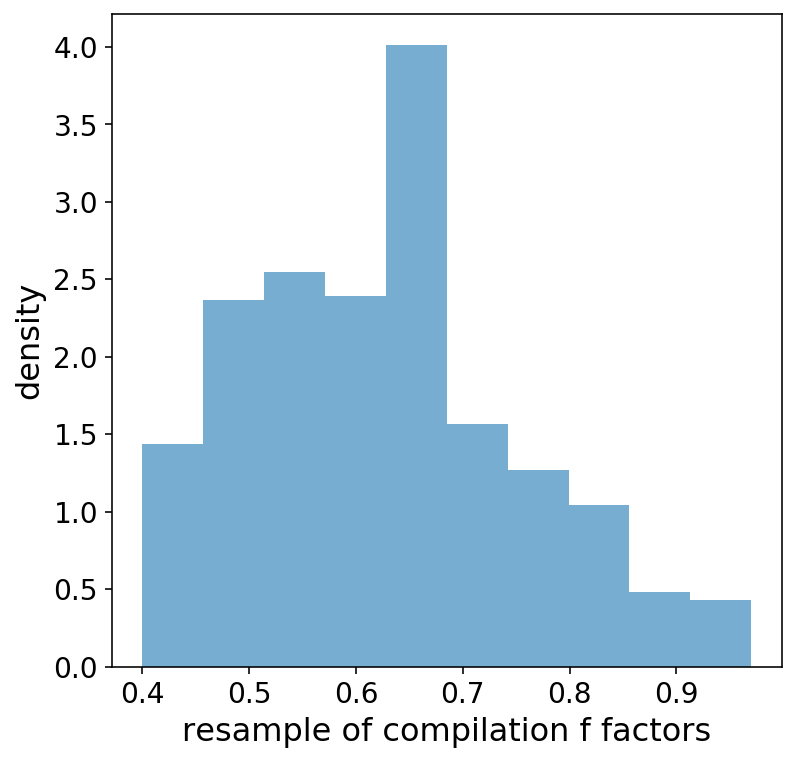

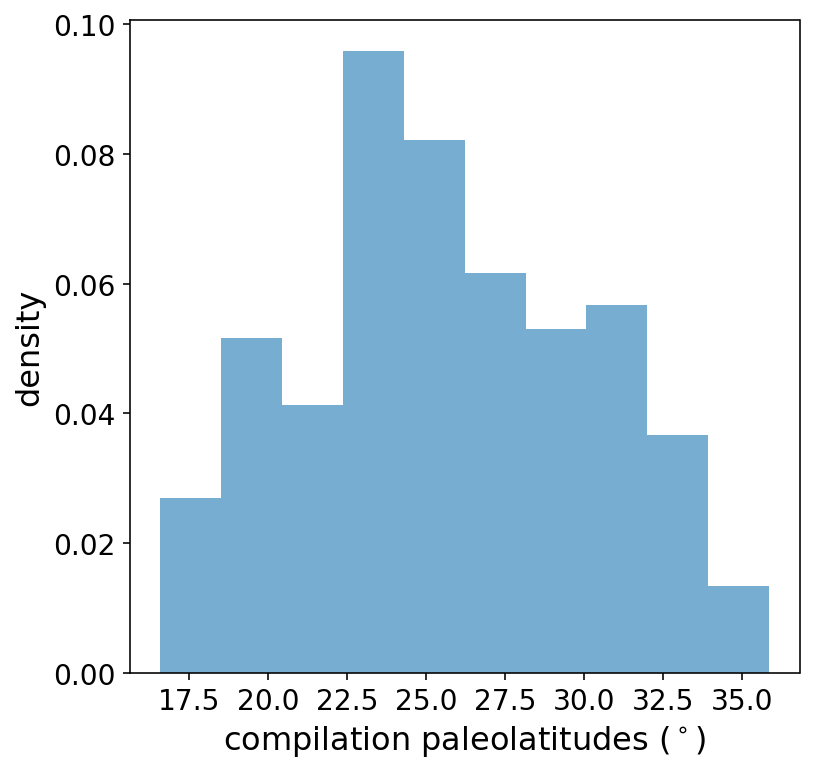

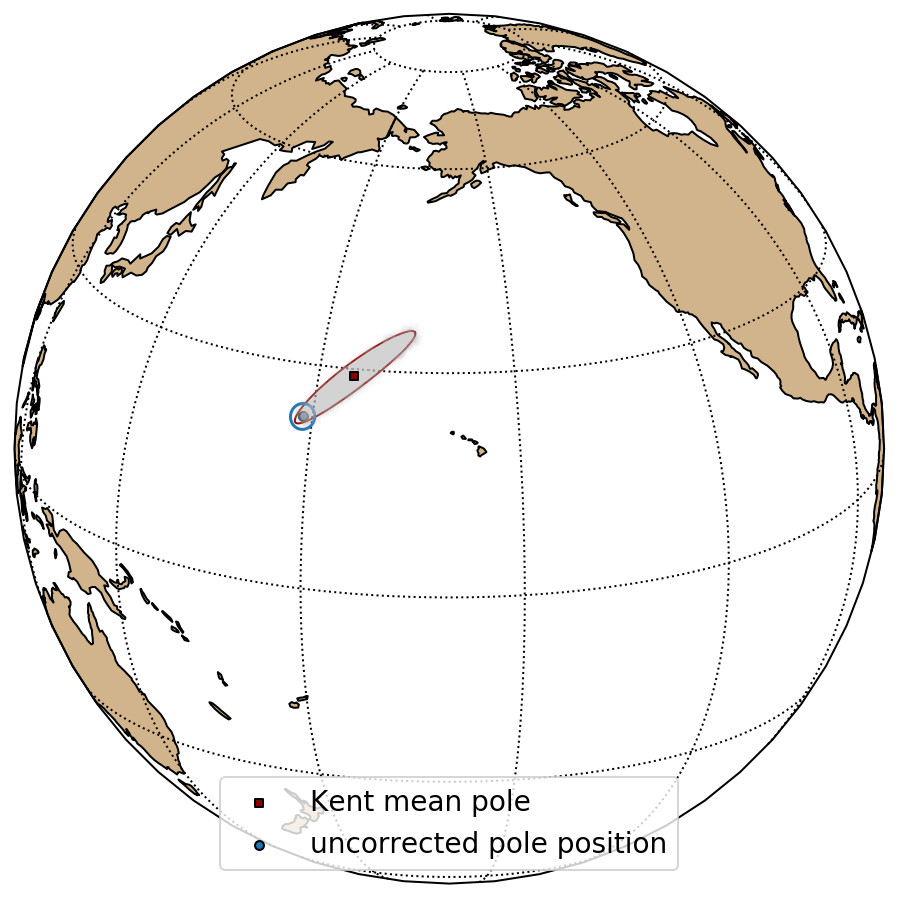

In [20]:
compilation_mean_lons_all, compilation_mean_lats_all, f_compilation_kent_distribution_95_all = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                                                                         A95, Cutface_lon, Cutface_lat, 
                                                                                                         f_from_compilation=all_f, n=5000, n_fish=500)

### Kent ellipse of Cut Face using hematite compilation f

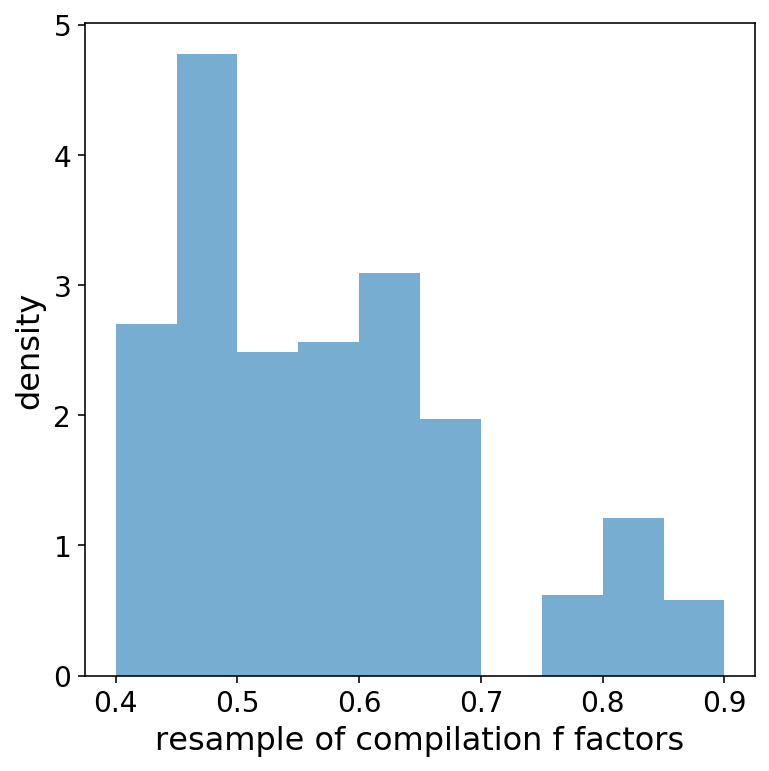

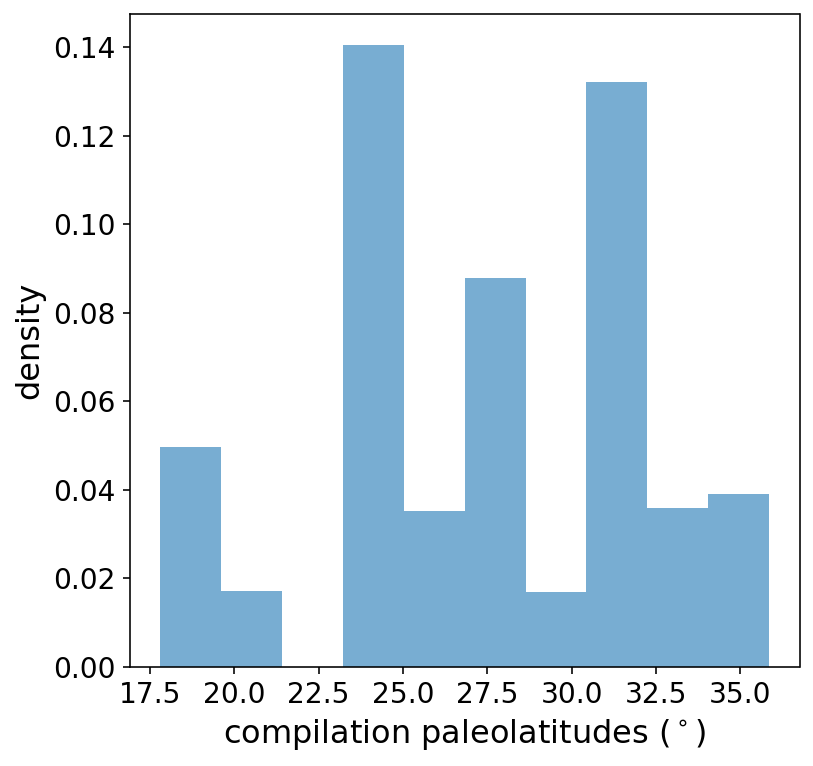

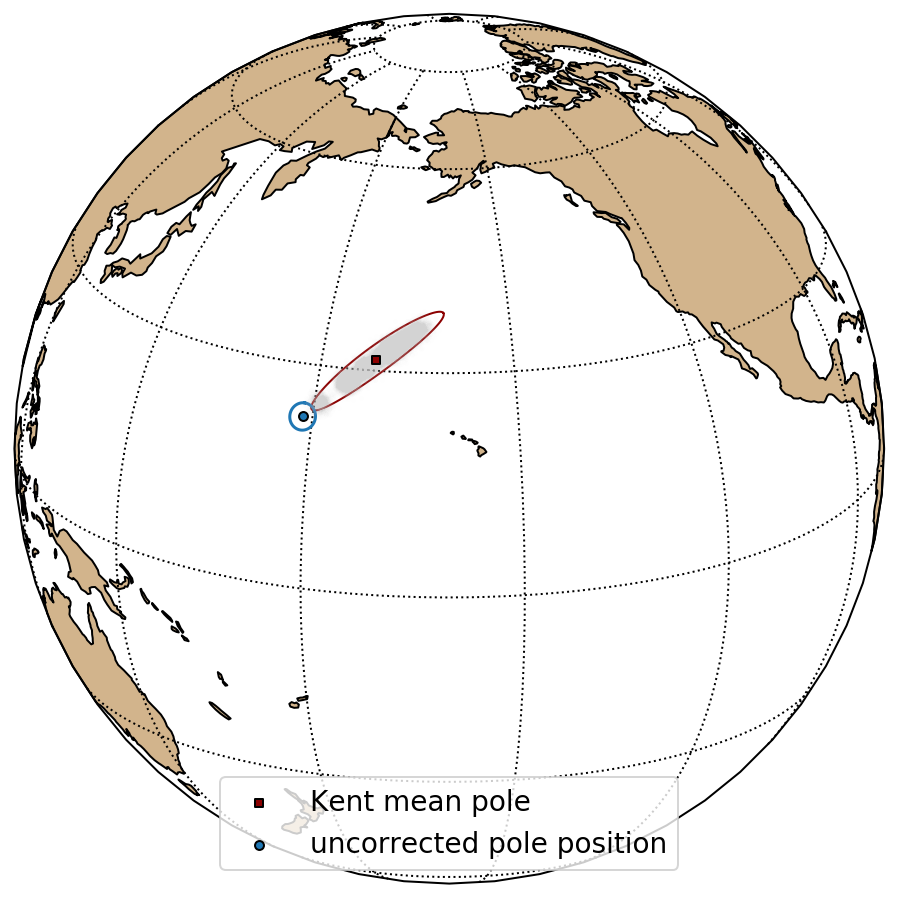

In [21]:
compilation_mean_lons_hem, compilation_mean_lats_hem, f_compilation_kent_distribution_95_hem = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                                                                         1.8, Cutface_lon, Cutface_lat, 
                                                                                                         f_from_compilation=hematite_f, n=5000, n_fish=500)

### Kent ellipse of Cut Face using magnetite compilation f

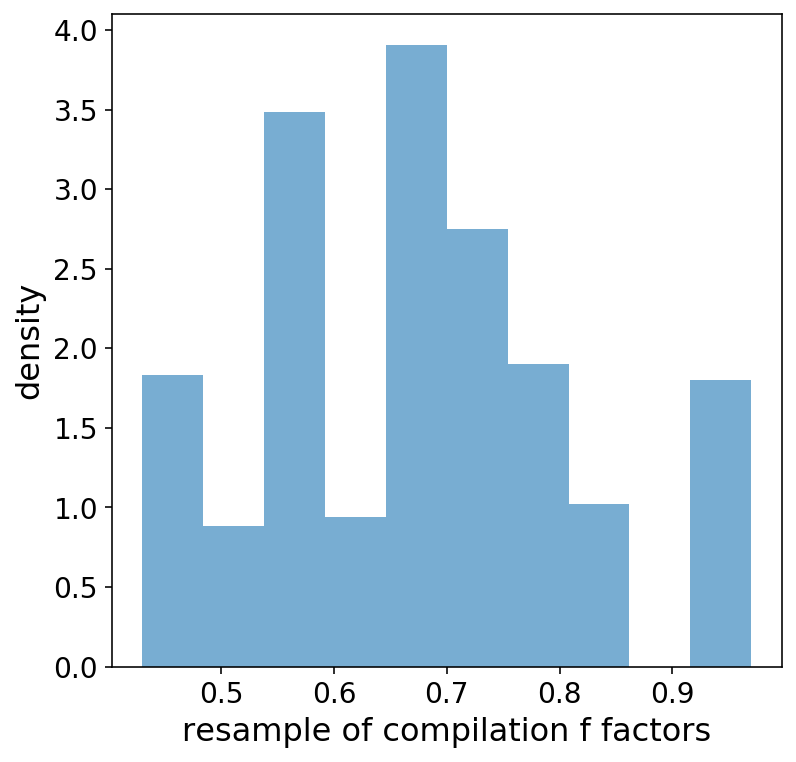

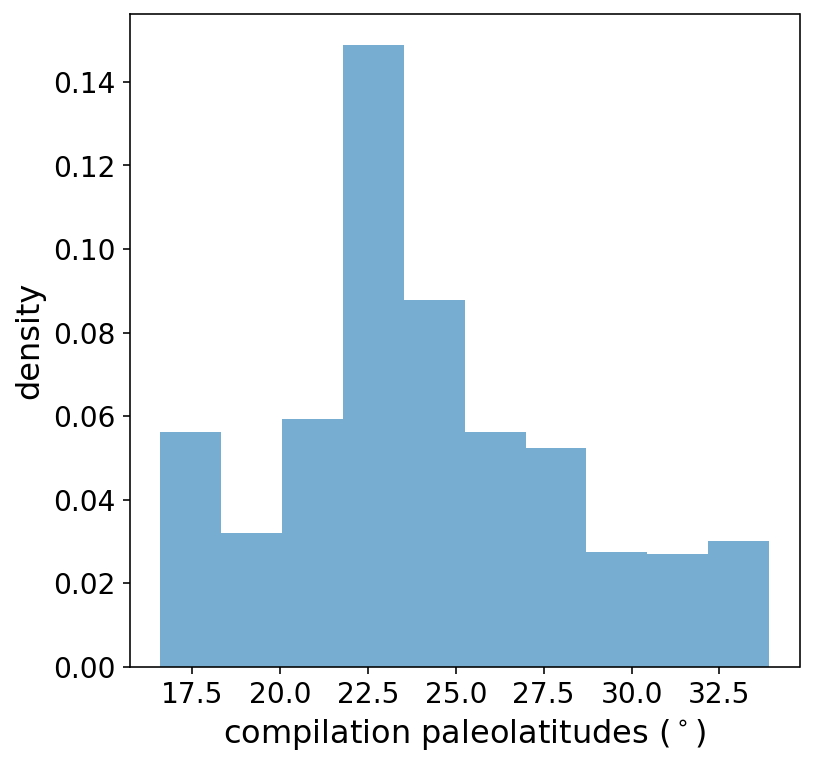

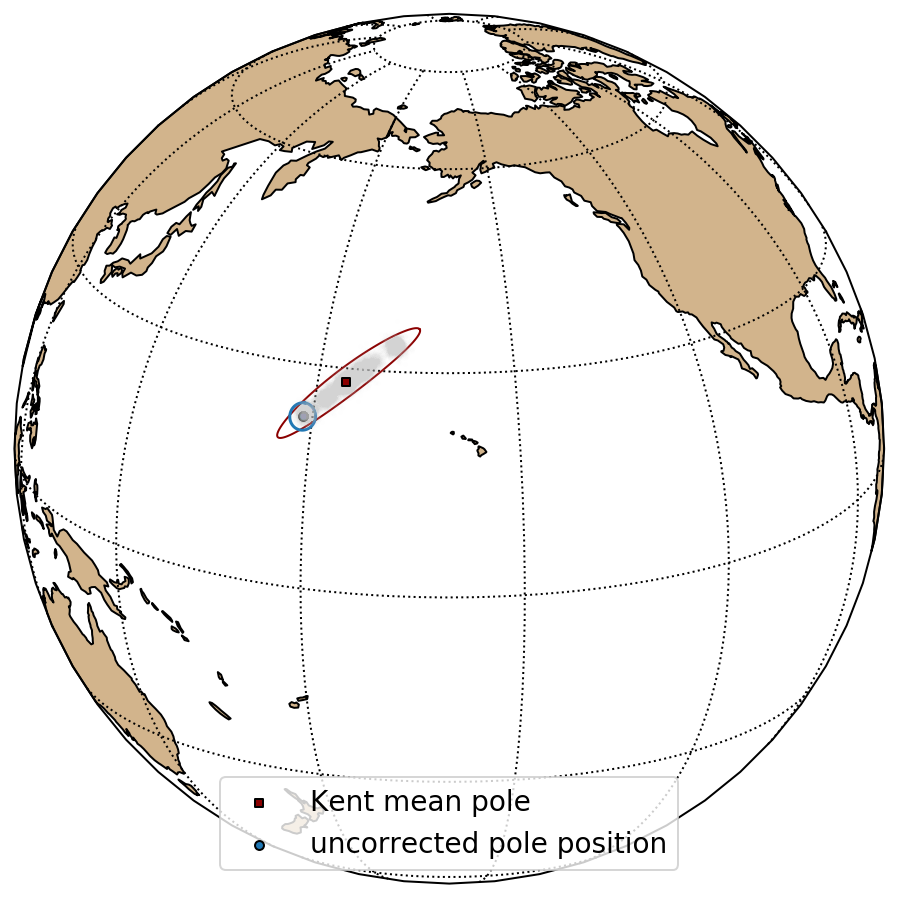

In [22]:
compilation_mean_lons_mag , compilation_mean_lats_mag , f_compilation_kent_distribution_95_mag = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                                                                         1.8, Cutface_lon, Cutface_lat, 
                                                                                                         f_from_compilation=magnetite_f, n=5000, n_fish=500)

### Kent ellipse of Cut Face using mixed mineralogy compilation f

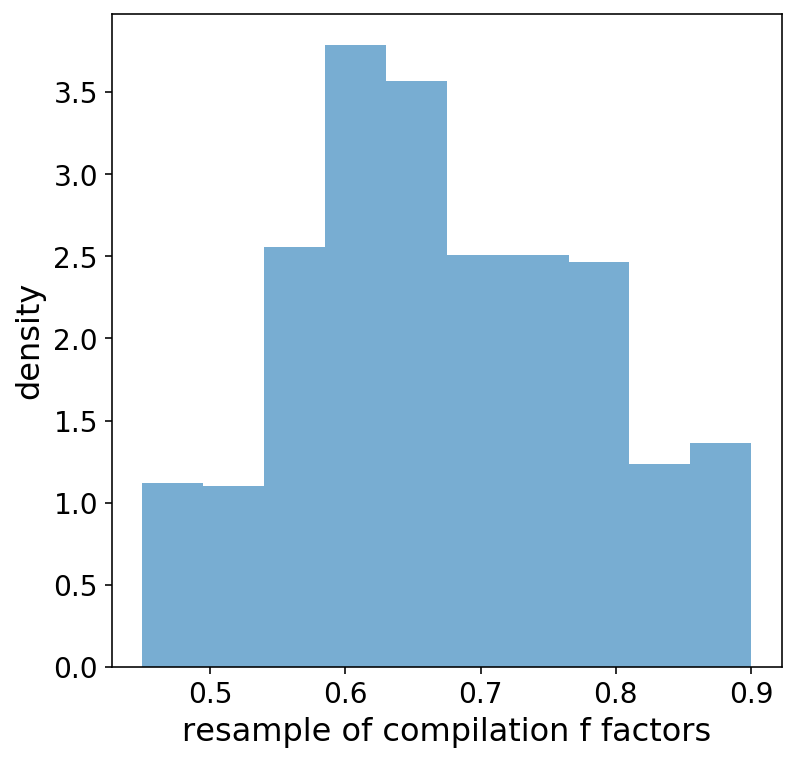

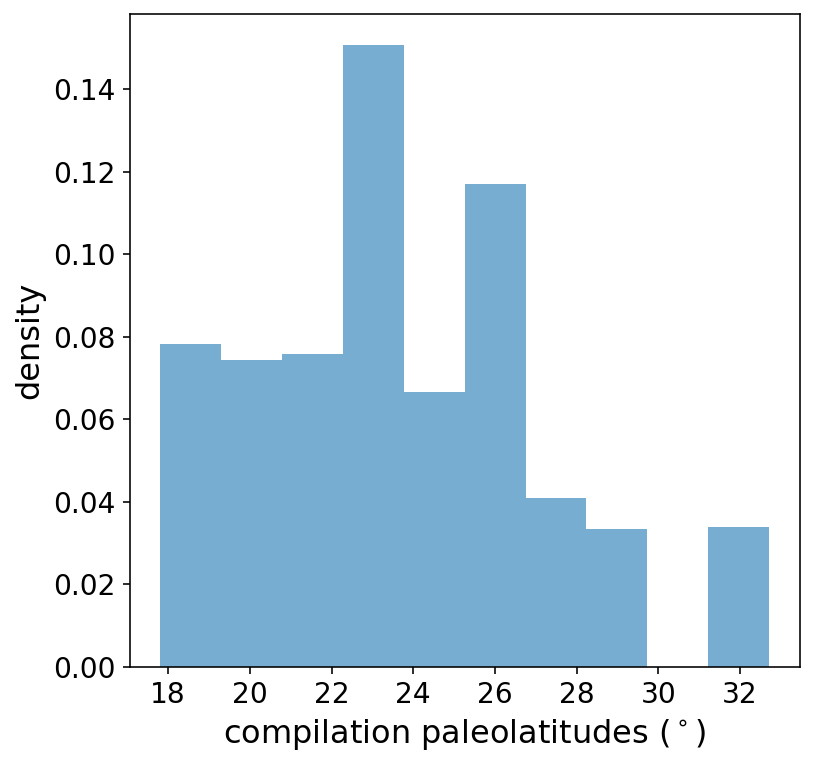

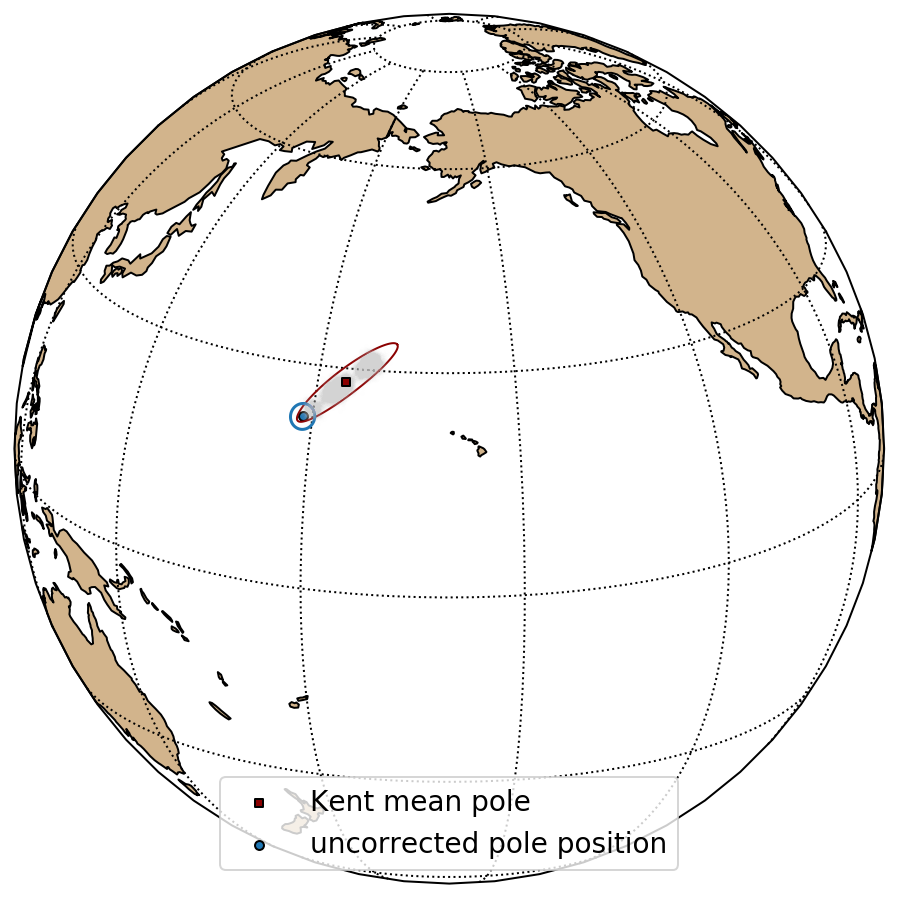

In [23]:
compilation_mean_lons_mixed, compilation_mean_lats_mixed, f_compilation_kent_distribution_95_mixed = find_compilation_kent(uncorrected_plon, uncorrected_plat, 
                                                                                                         A95, Cutface_lon, Cutface_lat, 
                                                                                                         f_from_compilation=mixed_f, n=5000, n_fish=500)

### calculate the Kent mean direction and associated f factor associated with the compilation Kent mean

In [51]:
compilation_kent_mean_dec, compilation_kent_mean_inc = pmag.vgp_di(f_compilation_kent_distribution_95_all['inc'], f_compilation_kent_distribution_95_all['dec'], Cutface_lat, Cutface_lon)
np.round(np.tan(np.radians(mean_ht['inc']))/np.tan(np.radians(compilation_kent_mean_inc)),2)

0.61

### now let's calculate the arc distance between the uncorrected mean pole and Kent mean pole

In [32]:
Kent_Fisher_arc_distance = pmag.angle([uncorrected_plon, uncorrected_plat], [f_compilation_kent_distribution_95_all['dec'], f_compilation_kent_distribution_95_all['inc']])
np.round(Kent_Fisher_arc_distance,2)

array([8.68])

In [33]:
compilation_kent_mean_inc

42.74430852433933

In [52]:
Kent_plat_high = pmag.plat(compilation_kent_mean_inc)+Kent_Fisher_arc_distance+A95
Kent_pinc_high = np.degrees(np.arctan(np.tan(np.radians(Kent_plat_high))*2))
np.round(np.tan(np.radians(mean_ht['inc']))/np.tan(np.radians(Kent_pinc_high)),2)


array([0.4])

In [40]:
f_compilation_kent_distribution_95_regulated = f_compilation_kent_distribution_95_all
f_compilation_kent_distribution_95_regulated['Zeta'] = Kent_Fisher_arc_distance[0]+A95

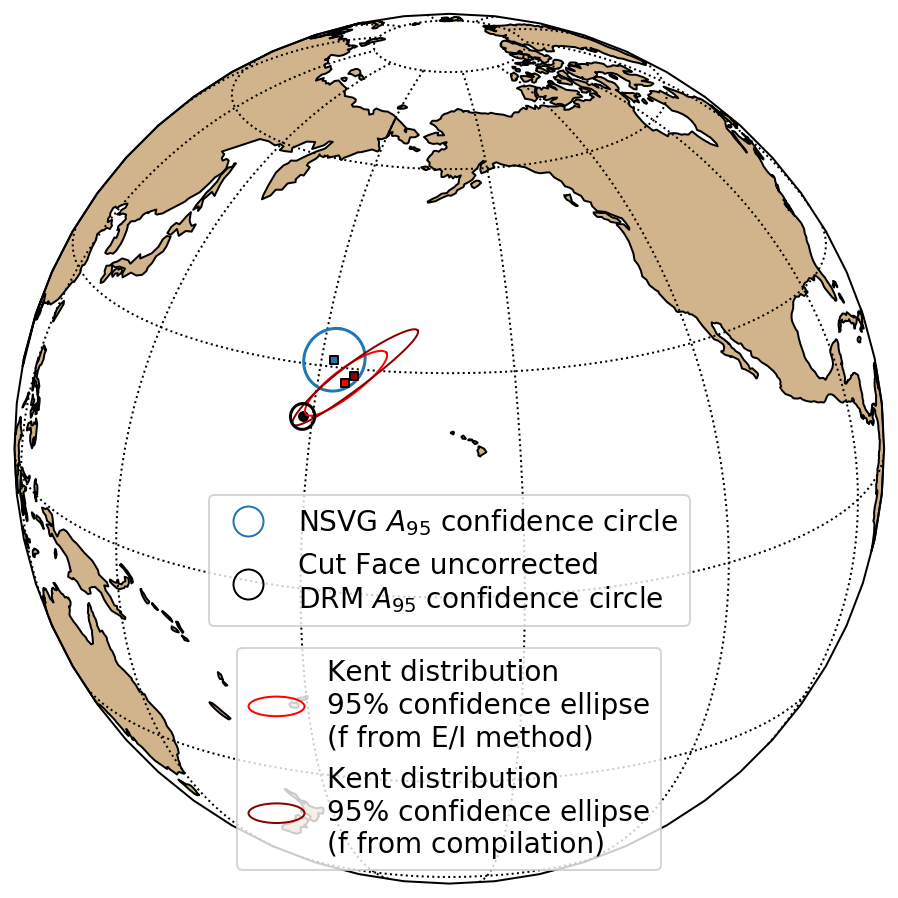

In [55]:
m = ipmag.make_orthographic_map(200, 20)
ipmag.plot_pole(m,182,31,4.2,label='North Shore Volcanic Group (upper NE)',marker='s',color='C0')
ipmag.plot_pole_ellipse(m,kent_distribution_95, color='r')
ipmag.plot_pole_ellipse(m,f_compilation_kent_distribution_95_all, color='darkred')
# ipmag.plot_pole_ellipse(m,f_compilation_kent_distribution_95_regulated, color='darkred')

ipmag.plot_pole(m,uncorrected_plon, uncorrected_plat, A95, color='k', label='uncorrected ')

# legend_1 = plt.legend([Line2D([0], [0], marker='o', color='k', markerfacecolor="none")],[], loc='lower center', fontsize=14)

circle_NSVG = Line2D([0], [0], marker='o', color='C0', label='NSVG $A _{95}$ confidence circle',
                        markerfacecolor='none', markersize=15, ls='none')
circle_uncorrected = Line2D([0], [0], marker='o', color='k', label='Cut Face uncorrected\nDRM $A _{95}$ confidence circle',
                        markerfacecolor='none', markersize=15, ls='none')

legend_1 = plt.legend(handles=[circle_NSVG, circle_uncorrected], bbox_to_anchor=[0.5, 0.28], loc=8, fontsize=14)
plt.gca().add_artist(legend_1)
plt.legend([mpatches.Circle((0.5, 0.5), 1, edgecolor='r', facecolor='none',linewidth=1), 
           mpatches.Circle((0.5, 0.5), 1, edgecolor='darkred', facecolor='none',linewidth=1)],
           ['Kent distribution\n95% confidence ellipse\n(f from E/I method)', 
            'Kent distribution\n95% confidence ellipse\n(f from compilation)'], loc='lower center', 
           handler_map={mpatches.Circle: HandlerEllipse()}, fontsize=14)


plt.savefig('../code_output/Cutface_NSVG_pole_comparison.pdf', bbox_inches='tight')

# Test the Kent distirbution method on synthetic data drawn from TK03 and data from Central Asia red beds

## synthetic data

In [19]:
n=150
synthetic_lat = pmag.plat(42)
synthetic_dec = mean_ht['dec']
synthetic_data = np.array(ipmag.tk03(n=n, dec=synthetic_dec, lat=synthetic_lat))

synthetic_decs = synthetic_data.T[0]
synthetic_incs = synthetic_data.T[1]

synthetic_vgp_lons = np.array([pmag.dia_vgp(synthetic_decs[i], synthetic_incs[i], 0, Cutface_lat, Cutface_lon) for i in range(n)]).T[0]
synthetic_vgp_lats = np.array([pmag.dia_vgp(synthetic_decs[i], synthetic_incs[i], 0, Cutface_lat, Cutface_lon) for i in range(n)]).T[1]
synthetic_pole = ipmag.fisher_mean(synthetic_vgp_lons, synthetic_vgp_lats)

f = 0.64
squished_incs = ipmag.squish(synthetic_incs, f)

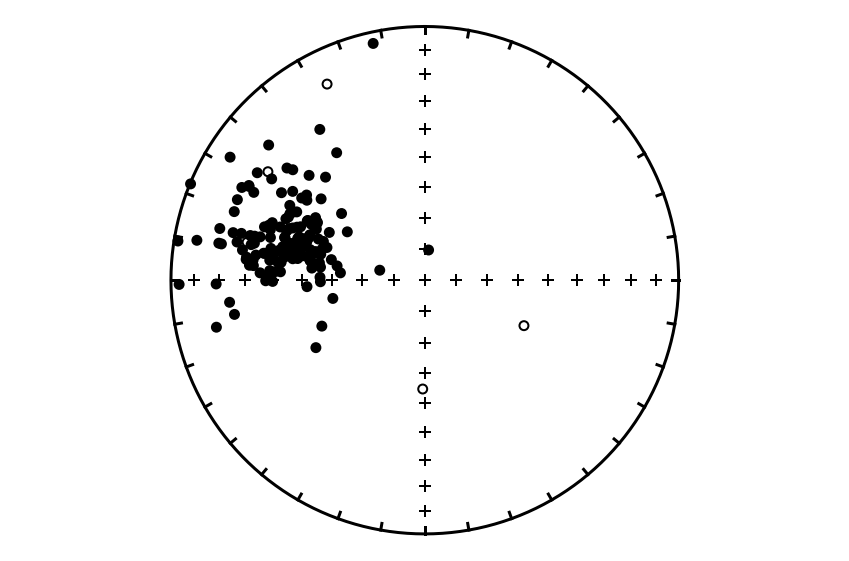

In [20]:
ipmag.plot_net()
ipmag.plot_di(synthetic_decs, synthetic_incs)

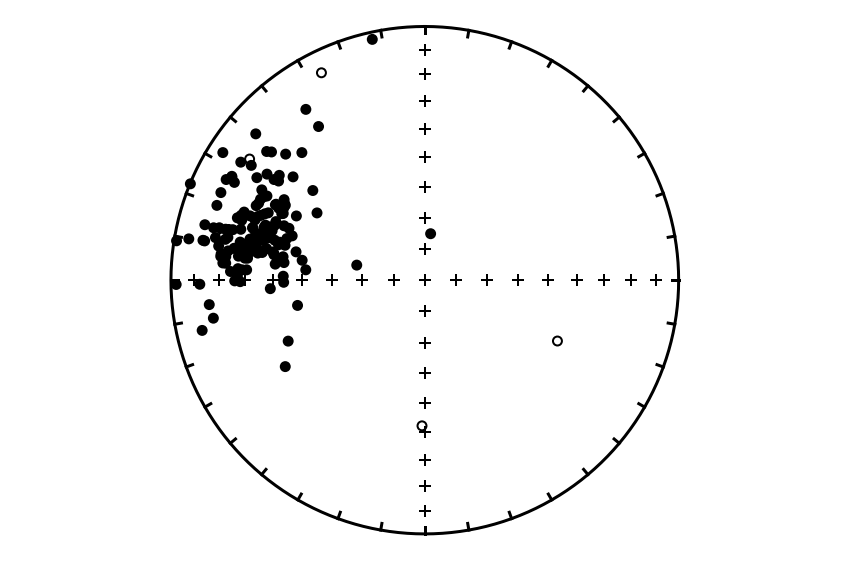

In [21]:
ipmag.plot_net()
ipmag.plot_di(synthetic_decs, squished_incs)

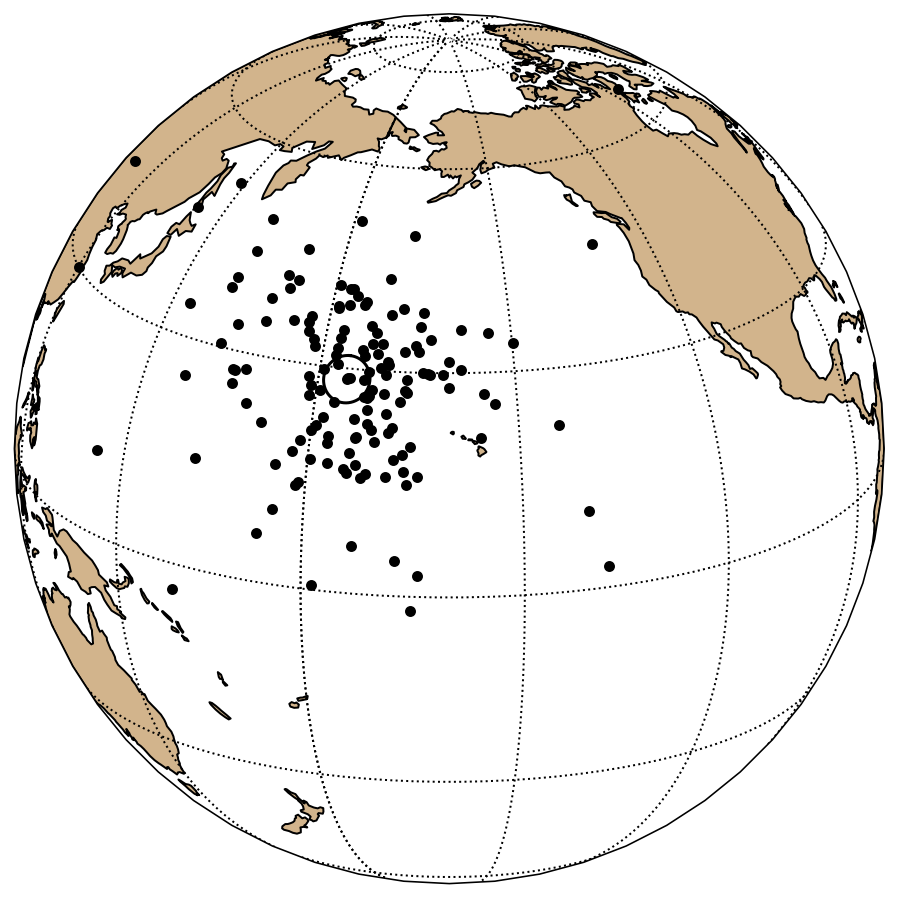

In [22]:
ax = ipmag.make_orthographic_map(200,20)
ipmag.plot_vgp(ax, synthetic_vgp_lons, synthetic_vgp_lats)
ipmag.plot_pole(ax, synthetic_pole['dec'], synthetic_pole['inc'], synthetic_pole['alpha95'])

plt.show()

Bootstrapping.... be patient



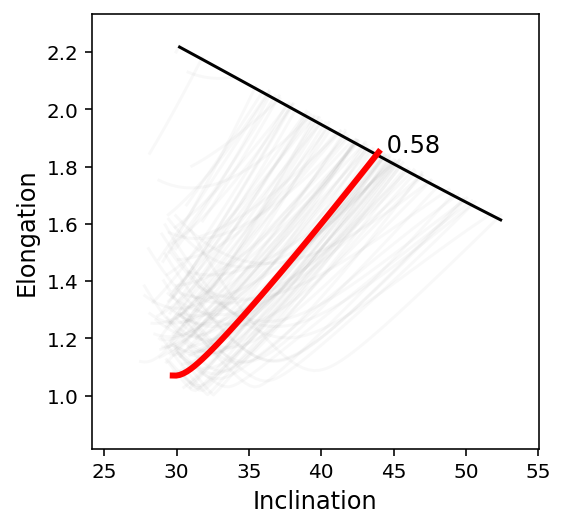

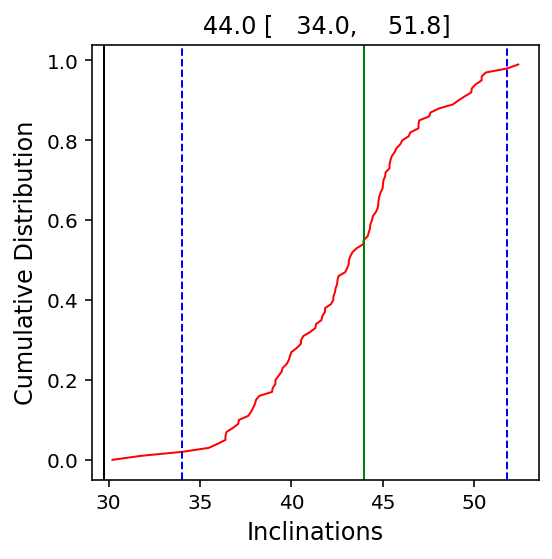

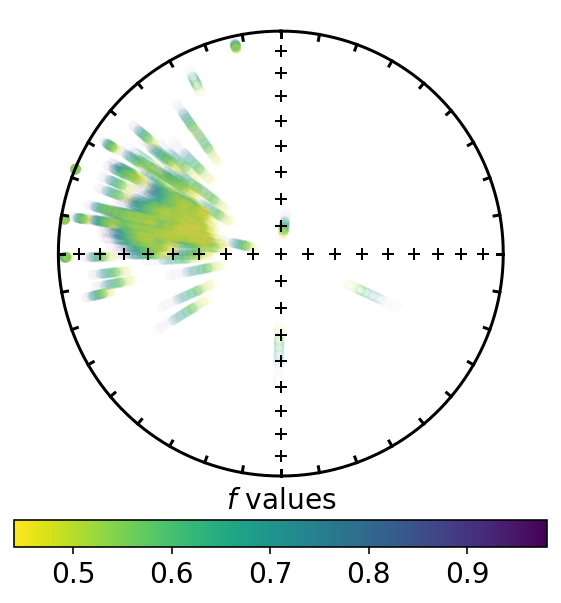

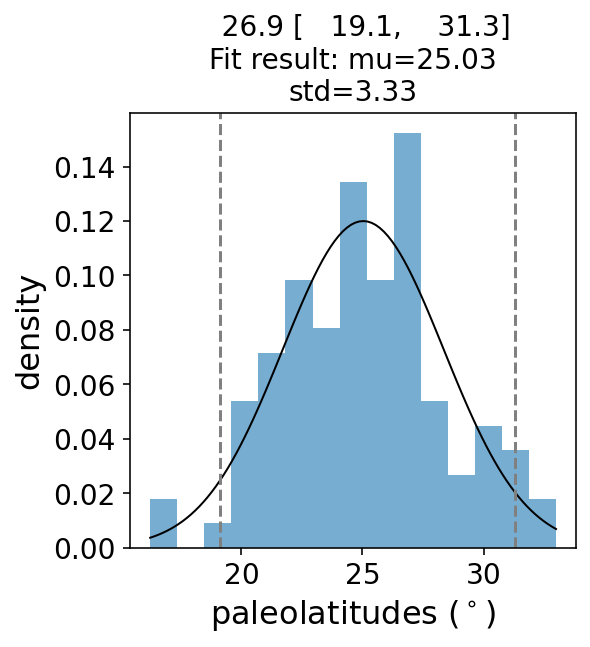

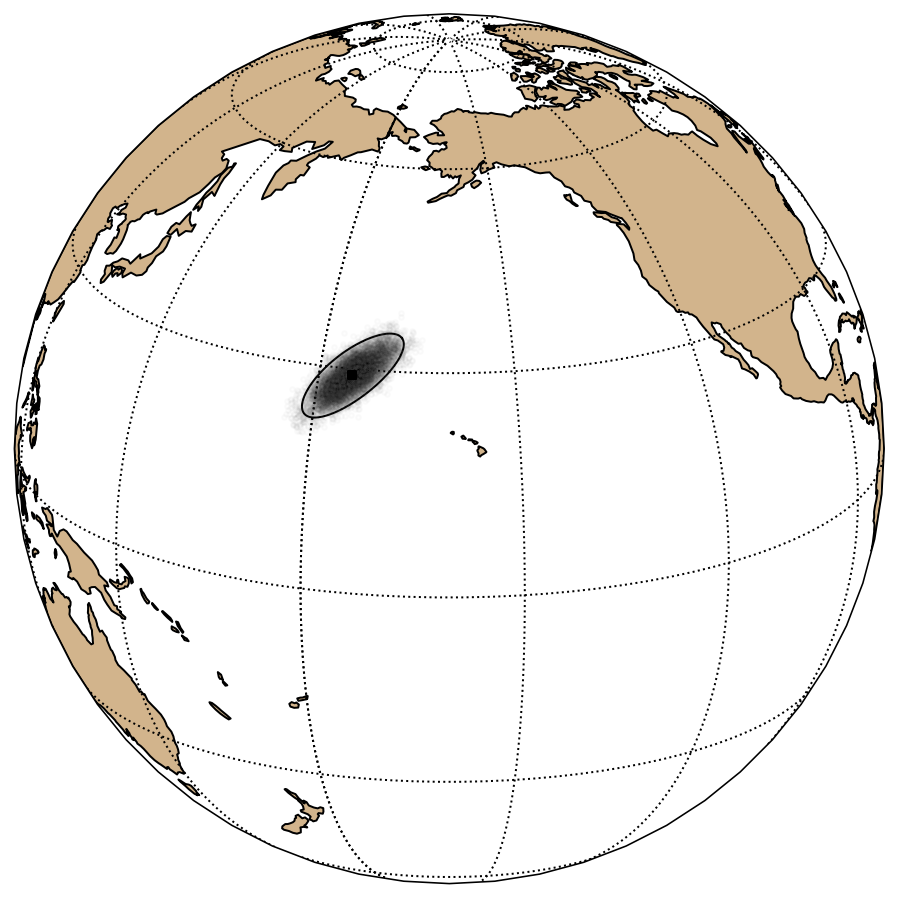

The original inclination was: 29.74

The corrected inclination is: 43.97
with bootstrapped confidence bounds of: 34.03 to 51.79
and elongation parameter of: 1.85
The flattening factor is: 0.58
with bootstrapped confidence bounds of: 0.85 to 0.45

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 185.1  Plat: 29.2
Major axis lon: 299.7  Major axis lat: 36.6
Minor axis lon: 67.6  Minor axis lat: 39.6
Major axis angle of 95% ellipse (Zeta): 8.2
Minor axis angle of 95% ellipse (Eta): 3.2
Number of directions in mean (n): 10000


In [23]:
result_dir, kent_stats, I, E, F = ipmag.find_ei_kent(np.array([synthetic_decs, squished_incs]).T, 
                                         site_latitude=Cutface_lat, 
                                         site_longitude=Cutface_lon, 
                                         nb=100,                 
                                         return_new_dirs=1,
                                         return_values=1,
                                         EI_color='r',
                                         resample_EI_color='grey',
                                         resample_EI_alpha=0.05,
                                         vgp_nb=100,
                                         cmap='viridis_r',
                                         central_longitude=200,
                                         central_latitude=20,) 

## Test the method on Li et al., 2020 data compiled by Vaes et al, 2021

In [62]:
Li2020a_slat = 30.85
Li2020a_slon = 98.3
Li2020a = pd.read_csv('../data/data_compiled/Li2020a.csv')
Li2020a_lower_interval = Li2020a[Li2020a['depth']<=382.2].reset_index(drop=1)
# Li2020a['DEC'] = [Li2020a['Ds'][i] if Li2020a['Is'][i]>=0 else (Li2020a['Ds'][i]+180)%360 for i in range(Li2020a.shape[0])]
# Li2020a['INC'] = [Li2020a['Is'][i] if Li2020a['Is'][i]>=0 else -Li2020a['Is'][i] for i in range(Li2020a.shape[0])]
Li2020a_lower_interval.head()

sample     #  depth    Dg    Ig    Ds    Is   Lat    Lon
0  GJ184  1109  382.2  76.7  23.8  78.4   8.8  12.2  190.4
1  GJ183  1110  380.2  74.7  33.0  77.6  18.2  15.4  186.5
2  GJ182  1111  378.2  45.3  36.3  52.6  25.8  38.9  195.8
3  GJ181  1112  375.2  42.6  15.2  45.0   5.9  39.3  212.5
4  GJ180  1113  373.2  34.7  25.2  40.2  17.3  46.6  210.1

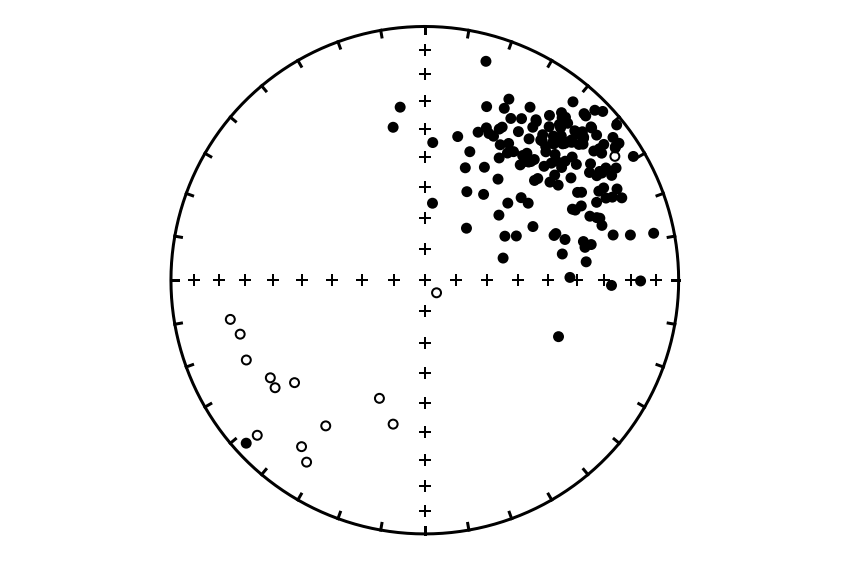

In [61]:
ipmag.plot_net()
ipmag.plot_di(Li2020a_lower_interval['Ds'], Li2020a_lower_interval['Is'])

In [84]:
Li2020a_lower_interval_flip = pmag.flip(ipmag.make_di_block(Li2020a_lower_interval['Ds'], Li2020a_lower_interval['Is']), combine=1)
# Li2020a_lower_interval_flip

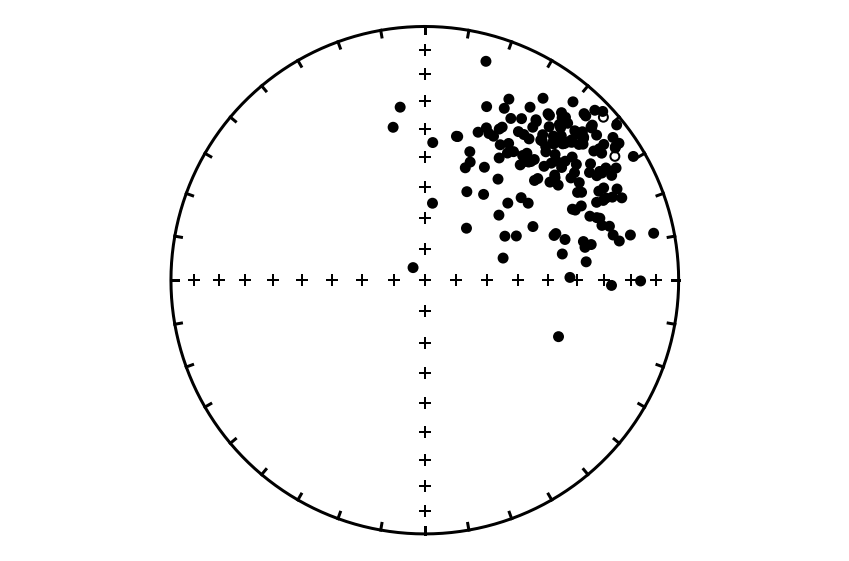

In [85]:
ipmag.plot_net()
ipmag.plot_di(di_block=Li2020a_lower_interval_flip)

Bootstrapping.... be patient



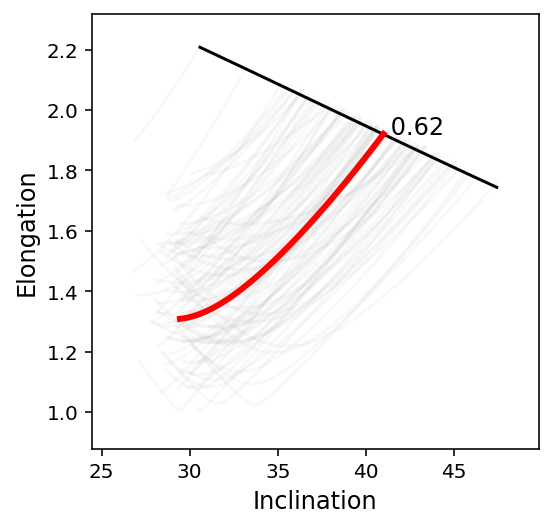

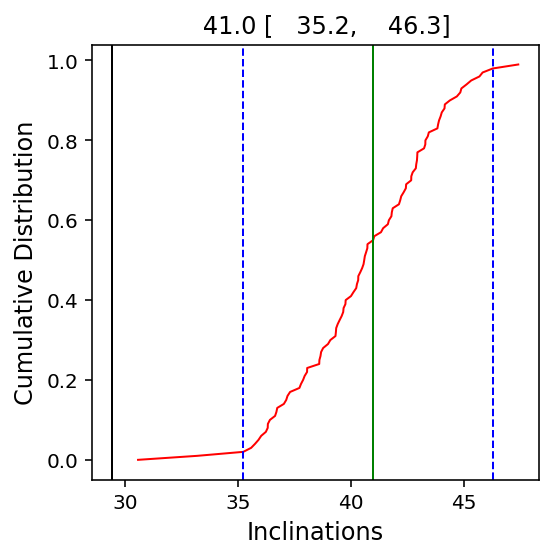

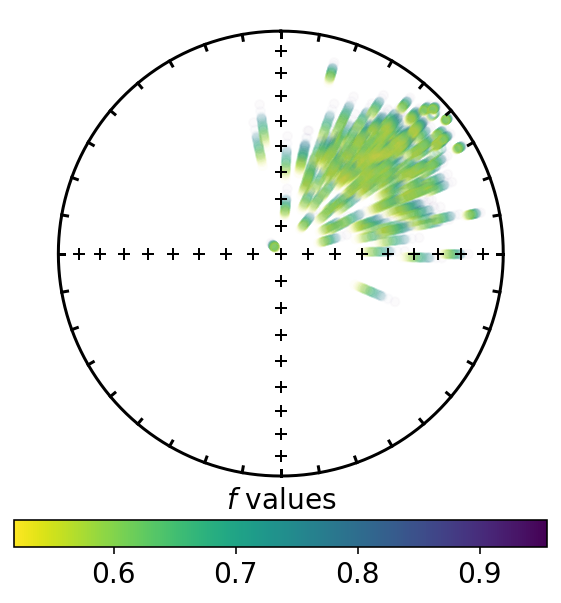

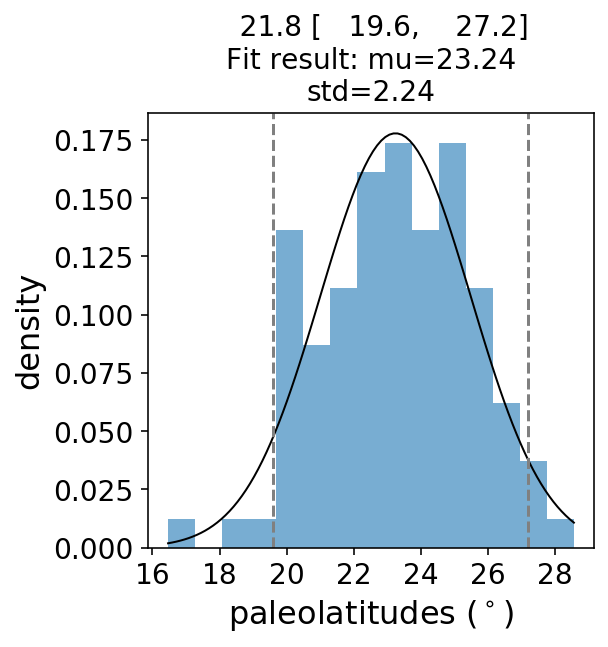

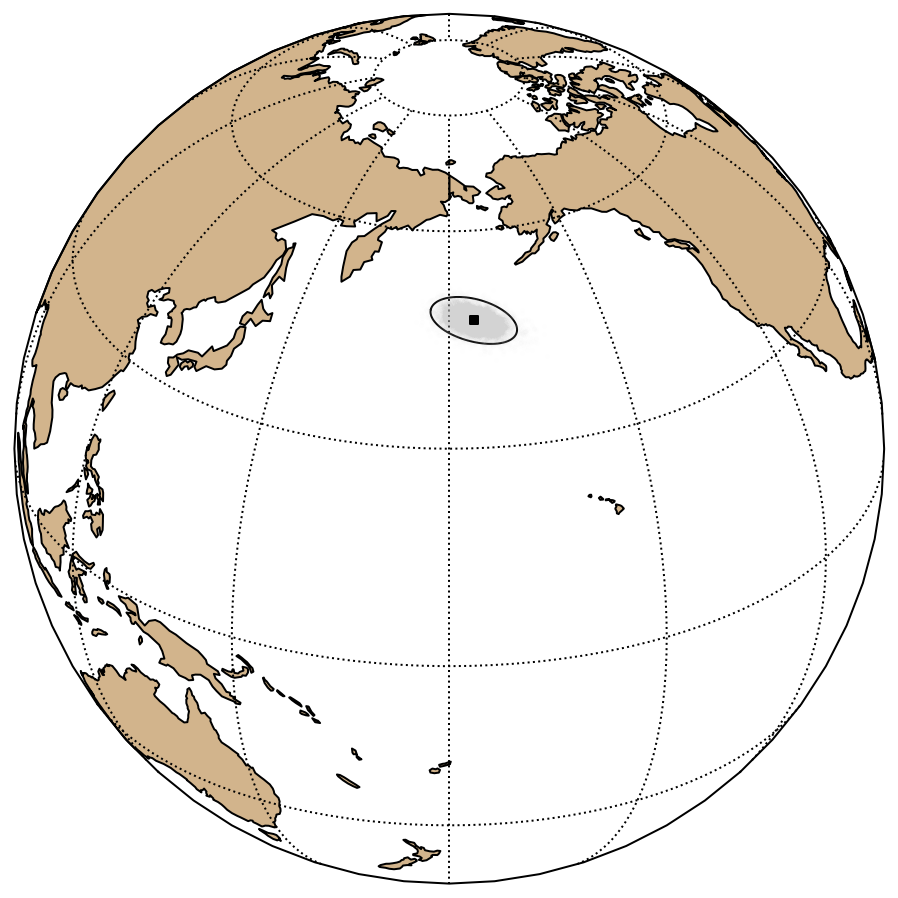

The original inclination was: 29.45

The corrected inclination is: 41.0
with bootstrapped confidence bounds of: 35.25 to 46.3
and elongation parameter of: 1.92
The flattening factor is: 0.62
with bootstrapped confidence bounds of: 0.8 to 0.54

The Kent mean incorporating inclination flattening uncertainty is:
Plon: 184.8  Plat: 47.1
Major axis lon: 81.0  Major axis lat: 12.5
Minor axis lon: 340.3  Minor axis lat: 40.2
Major axis angle of 95% ellipse (Zeta): 5.9
Minor axis angle of 95% ellipse (Eta): 2.9
Number of directions in mean (n): 10000


In [89]:
Li2020a_result_dir, Li2020a_kent, Li2020a_I, Li2020a_E, Li2020a_F = ipmag.find_ei_kent(Li2020a_lower_interval_flip, 
                                                                            site_latitude=Li2020a_slat, 
                                                                            site_longitude=Li2020a_slon, 
                                                                            nb=100,
                                                                            return_new_dirs=1,
                                                                            return_values=1,
                                                                            EI_color='r',
                                                                            resample_EI_color='grey',
                                                                            resample_EI_alpha=0.05,
                                                                            vgp_nb=100,
                                                                            cmap='viridis_r',
                                                                            central_longitude=180,
                                                                            central_latitude=30,) 